#### Importing Important Library

In [66]:
# !pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Lasso , Ridge , ElasticNet , LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import xgboost as xgb
import pickle 

Data Downloaded from (# https://www.kaggle.com/datasets/shivam2503/diamonds)

In [5]:
df = pd.read_csv('diamonds.csv',index_col= 0)

In [6]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [7]:
df.tail()

,carat,cut,color,clarity,depth,table,price,x,y,z
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53940,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


In [8]:
df.shape

(53940, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


There is no null value in data set

In [10]:
df.duplicated().sum()

146

#### There are 146 duplicates row found in dataset 

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.duplicated().sum()

0

#### Splitting Numerical and Categorical Features columns

In [13]:
numerical_col = df.select_dtypes(include=[np.number]).columns
categorical_col = df.select_dtypes(exclude=[np.number]).columns

In [14]:
print("Numerical_col : " , numerical_col)
print("Categorical_col : ", categorical_col)

Numerical_col :  Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')
Categorical_col :  Index(['cut', 'color', 'clarity'], dtype='object')


In [15]:
df[numerical_col].describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [16]:
df[categorical_col].describe()

,cut,color,clarity
count,53794,53794,53794
unique,5,7,8
top,Ideal,G,SI1
freq,21488,11262,13032


## Observations

1. The **Cut** feature contains **5 unique values**.
2. The **Color** feature comprises **7 unique values**.
3. The **Clarity** feature consists of **8 unique values**.


### Checking for Imbalanced Data


In [17]:

for i in df[categorical_col]:
    print(df[i].value_counts())
    print("-"*50)

cut
Ideal        21488
Premium      13748
Very Good    12069
Good          4891
Fair          1598
Name: count, dtype: int64
--------------------------------------------------
color
G    11262
E     9776
F     9520
H     8272
D     6755
I     5407
J     2802
Name: count, dtype: int64
--------------------------------------------------
clarity
SI1     13032
VS2     12229
SI2      9150
VS1      8156
VVS2     5056
VVS1     3647
IF       1784
I1        740
Name: count, dtype: int64
--------------------------------------------------


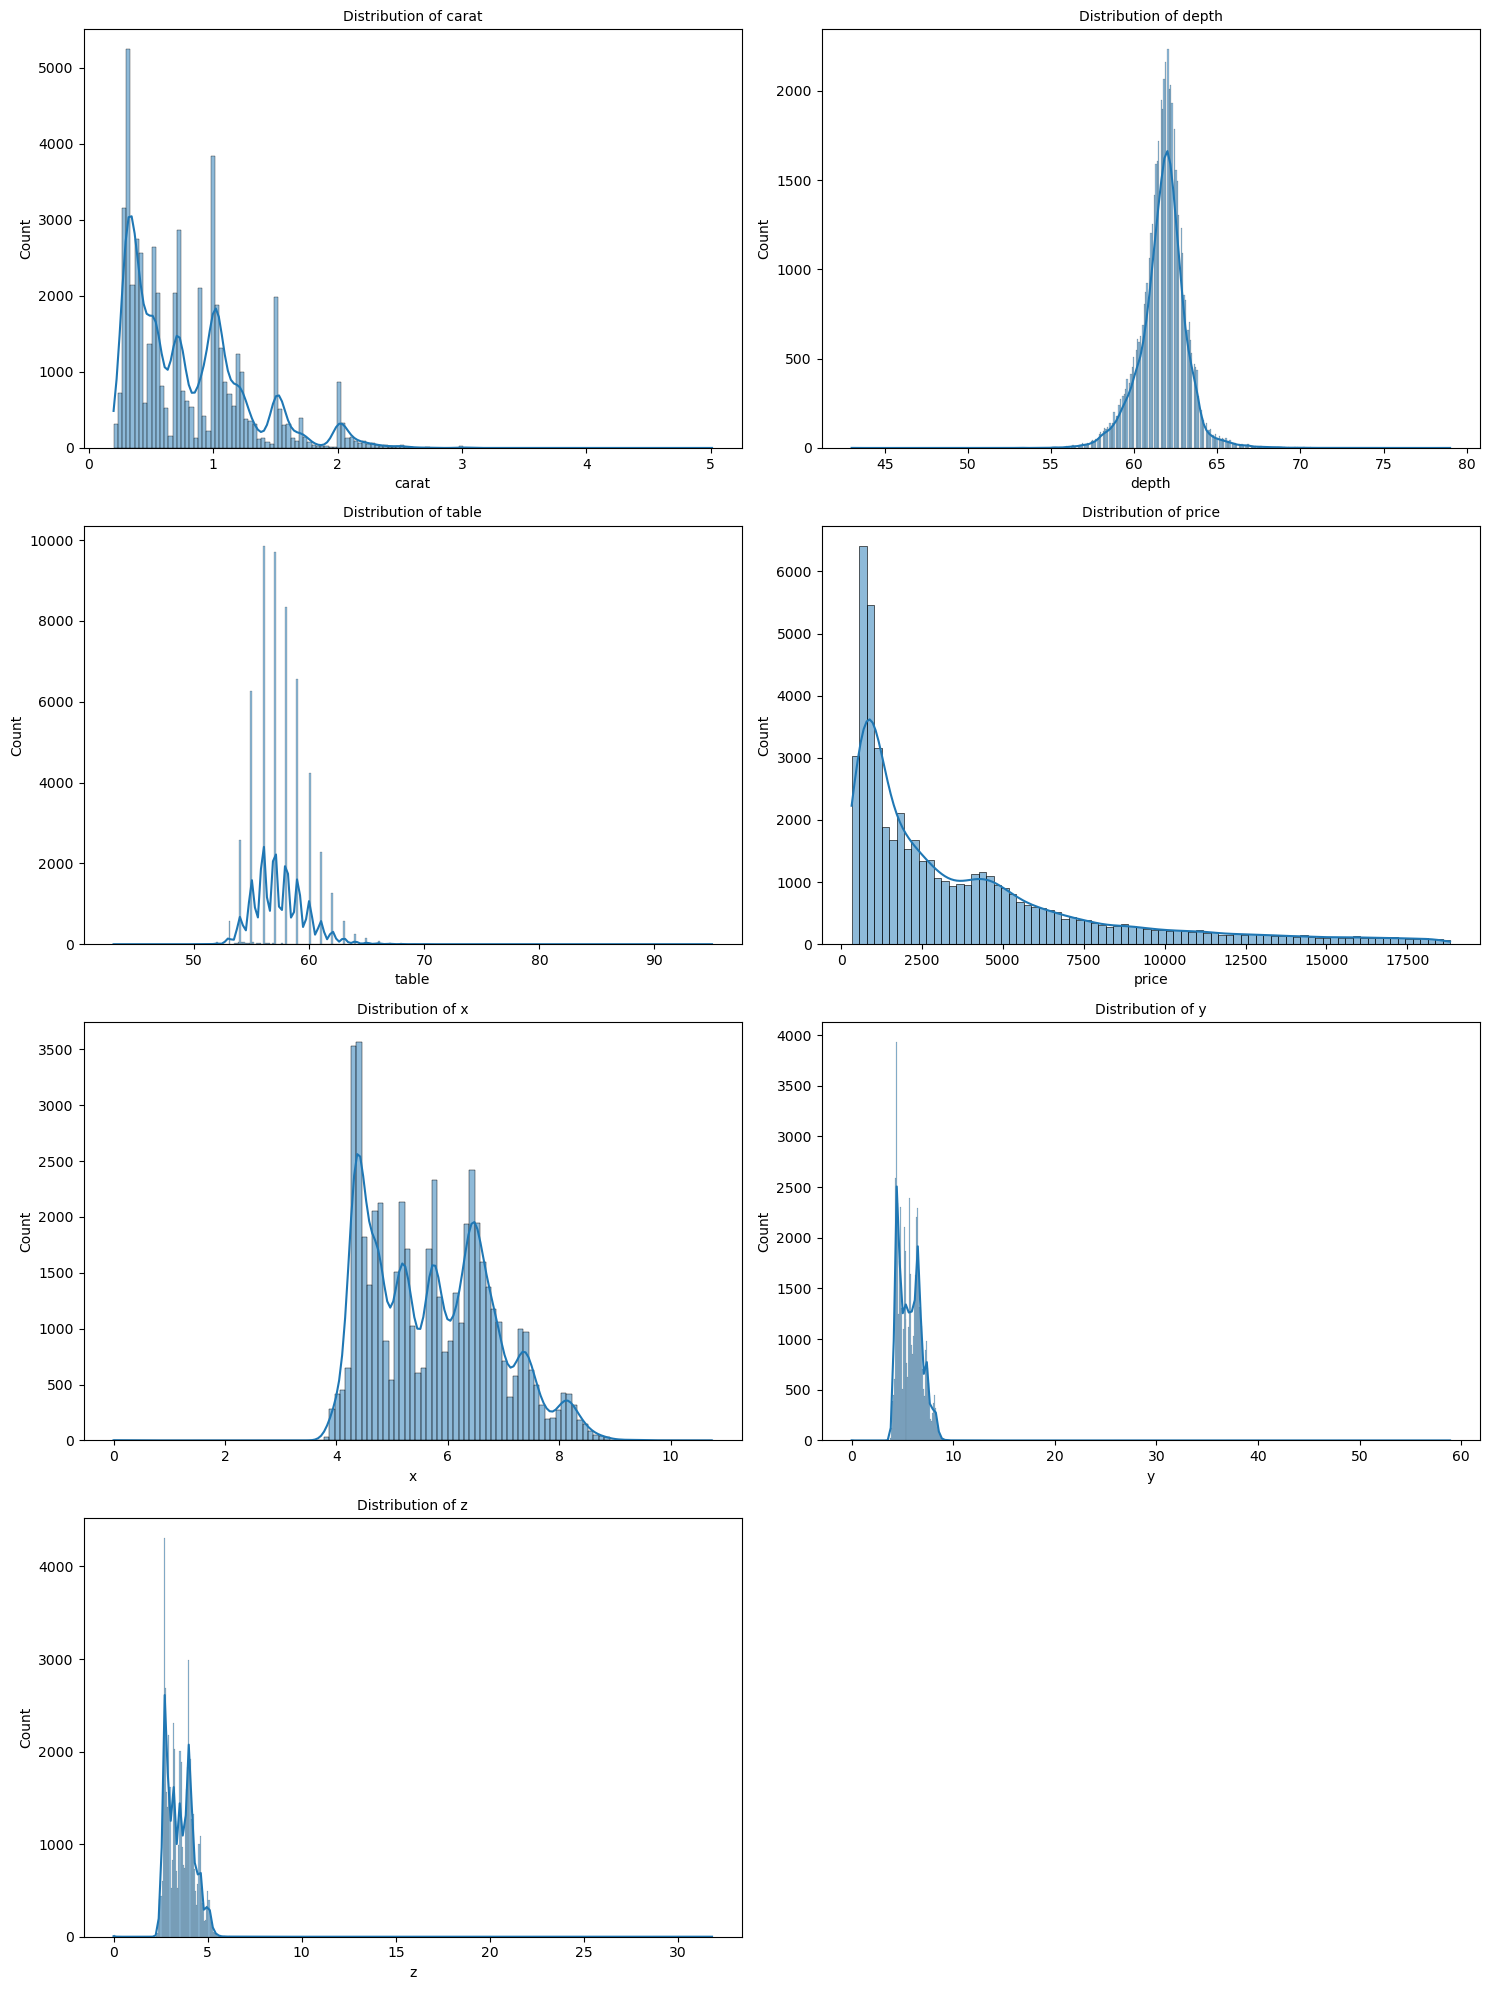

In [18]:
num_cols = len(numerical_col)


rows = (num_cols + 2) // 2  
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))  


axes = axes.flatten()


for i, col in enumerate(numerical_col):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=10)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()

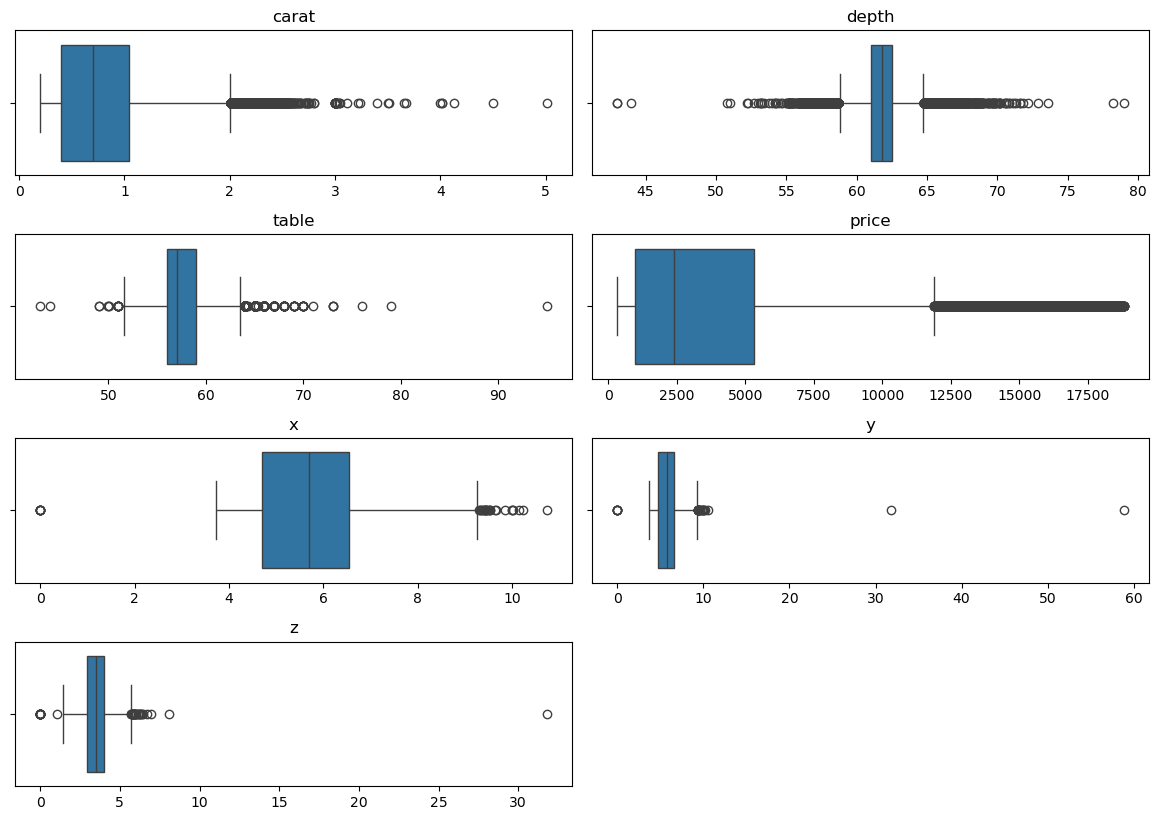

In [19]:
num_cols = len(numerical_col)  
rows = (num_cols // 2) + (num_cols % 2 > 0)  
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(11.7, 8.3))  


axes = axes.flatten()


for idx, feature in enumerate(numerical_col):
    sns.boxplot(data=df, x=feature, ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel("")  


for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


#### Note - There are many Outliers are available in the features

In [20]:
Q1 = df[numerical_col].quantile(0.25)
Q3 = df[numerical_col].quantile(0.75)

IQR = Q3 - Q1
print(IQR)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound)
print(upper_bound)


carat       0.64
depth       1.50
table       3.00
price    4375.75
x           1.83
y           1.82
z           1.12
dtype: float64
carat      -0.560
depth      58.750
table      51.500
price   -5612.625
x           1.965
y           1.990
z           1.230
dtype: float64
carat        2.000
depth       64.750
table       63.500
price    11890.375
x            9.285
y            9.270
z            5.710
dtype: float64


In [21]:
outliers = (df[numerical_col] < lower_bound) | (df[numerical_col] > upper_bound)

In [22]:
outlier_rows = df[outliers.any(axis=1)]

In [23]:
outlier_rows

,carat,cut,color,clarity,depth,table,price,x,y,z
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
25,0.31,Very Good,J,SI1,58.1,62.0,353,4.44,4.47,2.59
36,0.23,Good,F,VS1,58.2,59.0,402,4.06,4.08,2.37
43,0.26,Good,D,VS2,65.2,56.0,403,3.99,4.02,2.61
...,...,...,...,...,...,...,...,...,...,...
53883,0.71,Fair,D,VS1,65.4,59.0,2747,5.62,5.58,3.66
53887,0.70,Good,D,VS2,58.0,62.0,2749,5.78,5.87,3.38
53891,0.73,Good,E,SI1,57.9,55.0,2749,6.00,5.96,3.46
53896,0.70,Good,F,VS1,57.8,61.0,2751,5.83,5.79,3.36


In [24]:
df = df[~outliers.any(axis=1)]

In [25]:
df.shape

(47416, 10)

#### After Romoving Outliers 

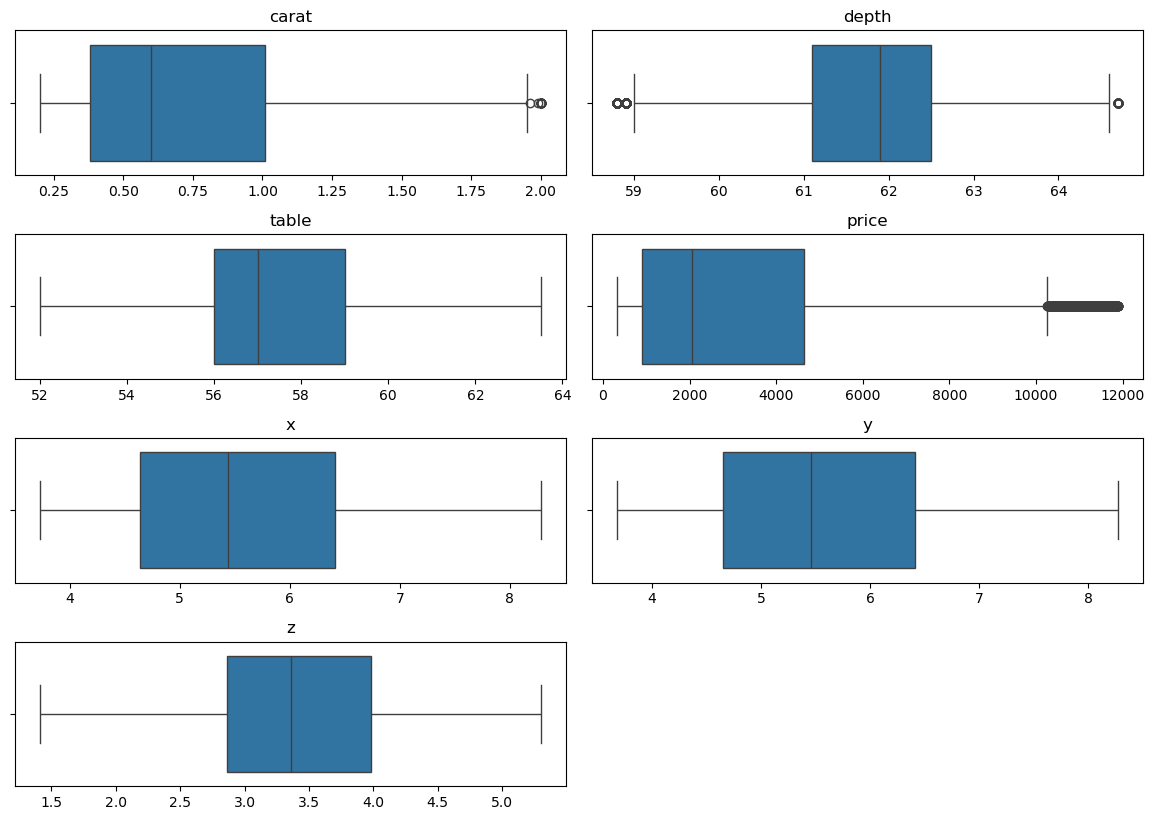

In [26]:
num_cols = len(numerical_col)  
rows = (num_cols // 2) + (num_cols % 2 > 0)  
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(11.7, 8.3))  


axes = axes.flatten()


for idx, feature in enumerate(numerical_col):
    sns.boxplot(data=df, x=feature, ax=axes[idx])
    axes[idx].set_title(feature)
    axes[idx].set_xlabel("")  


for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

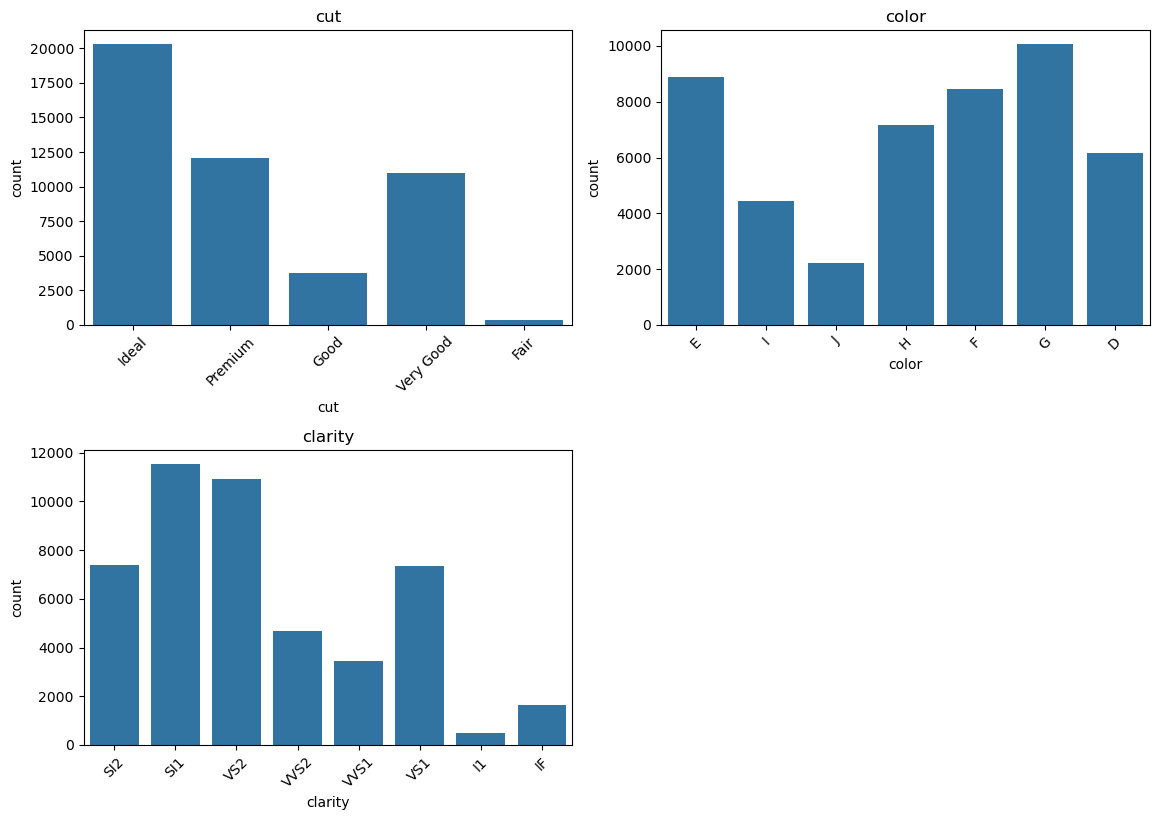

In [27]:
num_cols = len(categorical_col)
rows = (num_cols // 2) + (num_cols % 2 > 0)  
cols = 2


fig, axes = plt.subplots(rows, cols, figsize=(11.7, 8.3)) 


axes = axes.flatten()


for idx, col in enumerate(categorical_col):
    sns.countplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'{col}')
    axes[idx].tick_params(axis='x', rotation=45)


for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



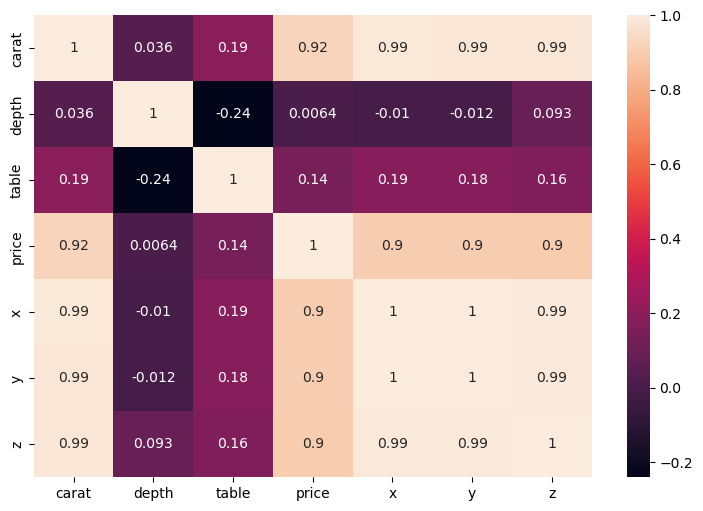

In [28]:
plt.figure(figsize=(9,6))
sns.heatmap(df[numerical_col].corr(),annot= True)
plt.show()

## Observations

1. **Carat and Price**: There are a strong positive relationship between carat and price, indicating that an increase in carat size is associated with an increase in price.

2. **Depth and Price**:  There is no relationship exists between depth and price.

3. **Table and Price**: There is a positive relationship between table size and price, implying that an increase in table size correlates with a higher  price.
   
4. **x and Price**: A positive relationship exists between the length of the diamond (x) and price, meaning that an increase in x leads to an increase in price.

5. **y and Price**: The width of the diamond (y) also has a positive relationship with price, indicating that an increase in y is associated with an increase in price.

6. **z and Price**: Similarly, there is a positive relationship between the height of the diamond (z) and price, meaning that an increase in z corresponds to a rise in price.


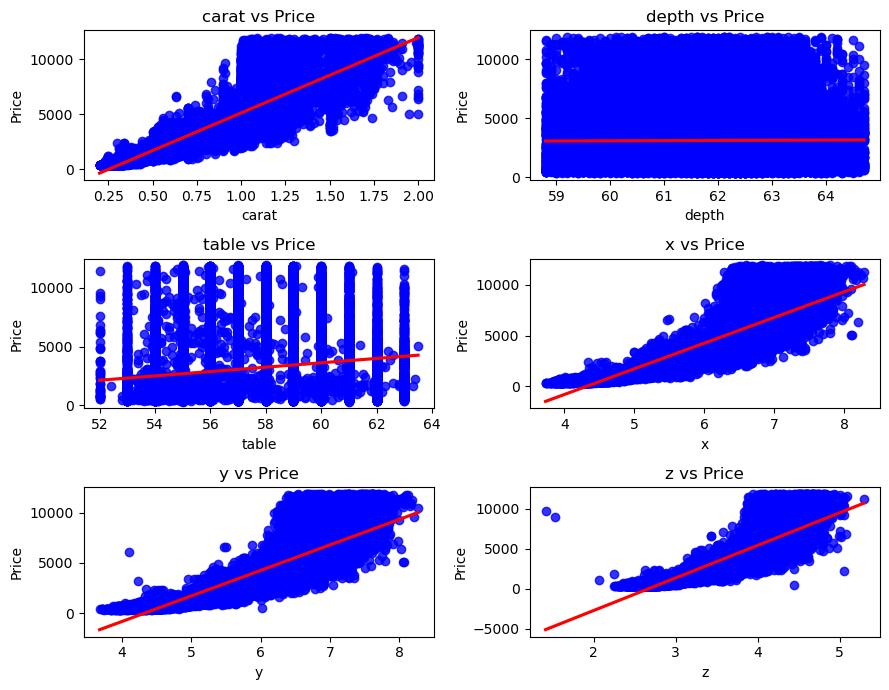

In [29]:
numerical_features1 = ['carat', 'depth', 'table', 'x', 'y', 'z']

plt.figure(figsize=(9, 7))  


for i, feature in enumerate(numerical_features1, 1):
    plt.subplot(3, 2, i)  
    sns.regplot(x=df[feature], y=df['price'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})  
    plt.title(f'{feature} vs Price')  
    plt.xlabel(f'{feature}')  
    plt.ylabel('Price')  

plt.tight_layout()  
plt.show()  

####  Splitting the dataset into  Independent features and Dependent feature

In [30]:
X = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
y = df['price']

In [31]:
X.shape , y.shape

((47416, 9), (47416,))

In [32]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,3.94,3.96,2.48


In [33]:
y.head()

1    326
2    326
4    334
5    335
6    336
Name: price, dtype: int64

#### Splitting Independent (X) and Dependent (y) into train test 

In [34]:
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
print('X_train Shape: ' ,X_train.shape) 
print('X_test Shape: ', X_test.shape) 
print('y_train Shape: ' ,y_train.shape) 
print('y_test Shape: ', y_test.shape) 

X_train Shape:  (31768, 9)
X_test Shape:  (15648, 9)
y_train Shape:  (31768,)
y_test Shape:  (15648,)


In [36]:
X_train

,carat,cut,color,clarity,depth,table,x,y,z
49770,0.50,Ideal,F,VVS2,61.6,56.0,5.11,5.08,3.14
32160,0.39,Ideal,G,VS2,62.2,53.9,4.66,4.69,2.90
5869,1.01,Good,G,SI2,63.7,58.0,6.35,6.31,4.03
6890,1.23,Premium,I,SI1,60.3,60.0,6.95,6.88,4.17
9562,1.10,Premium,E,SI2,60.9,60.0,6.66,6.61,4.04
...,...,...,...,...,...,...,...,...,...
12283,1.33,Premium,H,SI2,61.9,58.0,7.07,7.01,4.36
51033,0.48,Very Good,D,VVS2,59.5,57.0,5.16,5.12,3.06
44055,0.52,Very Good,F,VS2,61.9,59.0,5.11,5.14,3.17
952,0.50,Ideal,E,VVS2,62.2,54.0,5.09,5.11,3.17


In [37]:
numerical_Independent_feature = X_train.select_dtypes(include=[np.number]).columns

In [38]:
numerical_Independent_feature

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [39]:
for i in categorical_col:
    print(i)
    print(df[i].unique())
    print("-"*80)

cut
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
--------------------------------------------------------------------------------
color
['E' 'I' 'J' 'H' 'F' 'G' 'D']
--------------------------------------------------------------------------------
clarity
['SI2' 'SI1' 'VS2' 'VVS2' 'VVS1' 'VS1' 'I1' 'IF']
--------------------------------------------------------------------------------


Since categorial features are ordinal data set so encoding rank to feature 
ref - https://www.americangemsociety.org/ags-diamond-grading-system/

In [40]:
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

mapping the categorical feature

In [41]:
encoder = OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])
X_train[categorical_col] = encoder.fit_transform(X_train[categorical_col])

In [42]:
X_train

,carat,cut,color,clarity,depth,table,x,y,z
49770,0.50,4.0,2.0,5.0,61.6,56.0,5.11,5.08,3.14
32160,0.39,4.0,3.0,3.0,62.2,53.9,4.66,4.69,2.90
5869,1.01,1.0,3.0,1.0,63.7,58.0,6.35,6.31,4.03
6890,1.23,3.0,5.0,2.0,60.3,60.0,6.95,6.88,4.17
9562,1.10,3.0,1.0,1.0,60.9,60.0,6.66,6.61,4.04
...,...,...,...,...,...,...,...,...,...
12283,1.33,3.0,4.0,1.0,61.9,58.0,7.07,7.01,4.36
51033,0.48,2.0,0.0,5.0,59.5,57.0,5.16,5.12,3.06
44055,0.52,2.0,2.0,3.0,61.9,59.0,5.11,5.14,3.17
952,0.50,4.0,1.0,5.0,62.2,54.0,5.09,5.11,3.17


In [43]:
X_test

,carat,cut,color,clarity,depth,table,x,y,z
46754,0.46,Ideal,G,VVS1,61.6,55.0,5.00,5.03,3.09
10957,1.25,Ideal,H,SI2,61.6,54.0,6.94,6.88,4.25
28316,0.30,Good,H,SI1,63.8,55.0,4.20,4.26,2.70
28227,0.33,Ideal,H,VVS2,60.9,57.0,4.48,4.52,2.74
4064,0.31,Good,D,SI1,63.5,57.0,4.28,4.32,2.73
...,...,...,...,...,...,...,...,...,...
26722,0.32,Very Good,F,VS2,62.8,57.0,4.33,4.36,2.73
23100,1.59,Ideal,I,VS1,61.2,58.0,7.52,7.50,4.60
5900,1.20,Ideal,I,SI2,62.5,56.0,6.80,6.70,4.22
40556,0.41,Ideal,D,VS1,61.0,57.0,4.78,4.82,2.93


In [44]:
X_test[categorical_col] = encoder.transform(X_test[categorical_col])

In [45]:
X_test

,carat,cut,color,clarity,depth,table,x,y,z
46754,0.46,4.0,3.0,6.0,61.6,55.0,5.00,5.03,3.09
10957,1.25,4.0,4.0,1.0,61.6,54.0,6.94,6.88,4.25
28316,0.30,1.0,4.0,2.0,63.8,55.0,4.20,4.26,2.70
28227,0.33,4.0,4.0,5.0,60.9,57.0,4.48,4.52,2.74
4064,0.31,1.0,0.0,2.0,63.5,57.0,4.28,4.32,2.73
...,...,...,...,...,...,...,...,...,...
26722,0.32,2.0,2.0,3.0,62.8,57.0,4.33,4.36,2.73
23100,1.59,4.0,5.0,4.0,61.2,58.0,7.52,7.50,4.60
5900,1.20,4.0,5.0,1.0,62.5,56.0,6.80,6.70,4.22
40556,0.41,4.0,0.0,4.0,61.0,57.0,4.78,4.82,2.93


In [46]:
scaler = StandardScaler()
X_train[numerical_Independent_feature] = scaler.fit_transform(X_train[numerical_Independent_feature])
X_test[numerical_Independent_feature] = scaler.transform(X_test[numerical_Independent_feature])

In [47]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
49770,-0.561899,4.0,2.0,5.0,-0.172958,-0.621999,-0.444849,-0.483073,-0.475466
32160,-0.858622,4.0,3.0,3.0,0.370938,-1.661993,-0.904344,-0.883588,-0.871875
5869,0.813817,1.0,3.0,1.0,1.730676,0.368472,0.821314,0.780088,0.994553
6890,1.407264,3.0,5.0,2.0,-1.351398,1.358944,1.433973,1.365455,1.225792
9562,1.056591,3.0,1.0,1.0,-0.807502,1.358944,1.137855,1.088176,1.011070


In [48]:
X_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
46754,-0.669798,4.0,3.0,6.0,-0.172958,-1.117234,-0.557170,-0.534421,-0.558051
10957,1.461213,4.0,4.0,1.0,-0.172958,-1.612470,1.423762,1.365455,1.357929
28316,-1.101395,1.0,4.0,2.0,1.821325,-1.117234,-1.374050,-1.325180,-1.202216
28227,-1.020471,4.0,4.0,5.0,-0.807502,-0.126763,-1.088142,-1.058171,-1.136148
4064,-1.074421,1.0,0.0,2.0,1.549378,-0.126763,-1.292362,-1.263563,-1.152665


### Finding the best sutable model for diamond prediction

In [49]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=5000),  
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),  
    'Logistic Regression': LogisticRegression(max_iter=1000) , 
    'XGBRegressor' : xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=1000)
}

# Train and evaluate models on the scaled data
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results[name] = {
        'R_square': r2,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse
    }

# Create the DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Identify the best model based on R²
best_model_name = results_df['R_square'].idxmax()
print(f'The best model is: {best_model_name}')

                     R_square  Mean Absolute Error  Mean Squared Error
Linear Regression    0.914902           563.075971       647107.858898
Ridge Regression     0.914904           563.134237       647096.354825
Lasso Regression     0.914903           563.045950       647097.903497
Elastic Net          0.896383           668.261679       787934.190397
Logistic Regression  0.883697           587.393788       884400.047546
XGBRegressor         0.980628           208.250498       147311.881169
The best model is: XGBRegressor


In [58]:
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [59]:
y_pred = model.predict(X_test)

In [60]:
y_pred

array([1525.657 , 6290.0234,  417.7534, ..., 4776.135 , 1090.8417,
        999.6329], dtype=float32)

#### Checking true values and Predicted Values

In [61]:
results_df = pd.DataFrame({
    'True Values': y_test,
    'Predicted Values': y_pred
})

print(results_df)

       True Values  Predicted Values
46754         1800       1525.656982
10957         4900       6290.023438
28316          432        417.753387
28227          666        716.137512
4064           571        559.746033
...            ...               ...
26722          645        661.553772
23100        11119      10136.265625
5900          3931       4776.134766
40556         1151       1090.841675
40049         1112        999.632874

[15648 rows x 2 columns]


In [62]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R Square : ", r2)
print("MAE : " , mae)
print("MSE : ",mse)

R Square :  0.9806277751922607
MAE :  208.25049758981342
MSE :  147311.88116900853


In [63]:
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [64]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [65]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)